## Introduction
### Chargement des données et librairies 

In [1]:
pip install elosports

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels as sm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import sys
sys.path.append('/kaggle/input/ratingsffbad1')


from elosports.elo import Elo

from Module_elo import *

from glicko2_perso import Rating, Glicko2
from SmartRank_V3 import Rating, SmartRank

from collections import defaultdict

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB



In [3]:
#path= "ratings_FFBaD_bdd.xlsx"

In [4]:
#all_sheets = pd.read_excel(path, sheet_name=None) 
#Charge toutes les feuilles puis transforme en dictionnaire



Remarque : prenait trop de temps donc conversion de chaque feuille en CSV par la suite. Je joins les fichiers CSV pour éviter de devoir run les cellules de transformation

In [5]:
# Exporter toutes les feuilles en fichiers CSV pour gagner du temps et manipuler les feuilles une par une
#for sheet_name, df in all_sheets.items():
    #df.to_csv(f"{sheet_name}.csv", index=False)


In [6]:
df_matches_singles = pd.read_csv("/kaggle/input/ratingsffbad1/MatchesSingles.csv")
df_matches_doubles = pd.read_csv("/kaggle/input/ratingsffbad1/MatchesDoubles.csv")
df_event = pd.read_csv("/kaggle/input/ratingsffbad1/Event.csv")
df_country = pd.read_csv("/kaggle/input/ratingsffbad1/Country.csv")
df_conf = pd.read_csv("/kaggle/input/ratingsffbad1/Confederation.csv")
df_player = pd.read_csv("/kaggle/input/ratingsffbad1/Player.csv")
df_pair = pd.read_csv("/kaggle/input/ratingsffbad1/Pair.csv")
df_tournament = pd.read_csv("/kaggle/input/ratingsffbad1/Tournament.csv")
df_tournament_cat = pd.read_csv("/kaggle/input/ratingsffbad1/TournamentCategory.csv")


In [7]:
#On vérifie que les df contiennent bien uniquement les simples hommes et les doubles mixtes
print(df_matches_singles["EventId"].unique())
print(df_matches_doubles["EventId"].unique())

[1]
[5]


# Partie 1 : Analyse exploratoire des données

## 1.1 : Nettoyage et arrangements

In [8]:
# Filtre les joueurs masculins
df_male_players = df_player[df_player["Gender"] == True]
df_male_players.head()

,PlayerId,LastName,FirstName,CountryId,Gender,BirthDate,Height,Hand,Picture
0,12695,AXELSEN,Viktor,46,True,1994-01-04 00:00:00,194.0,1.0,https://img.bwfbadminton.com/image/upload/t_96...
1,12696,GINTING,Anthony Sinisuka,84,True,1996-05-11 00:00:00,171.0,1.0,https://img.bwfbadminton.com/image/upload/t_96...
2,12697,NARAOKA,Kodai,92,True,2001-06-30 00:00:00,NaN,NaN,https://img.bwfbadminton.com/image/upload/t_96...
3,12698,CHRISTIE,Jonatan,84,True,1997-09-15 00:00:00,179.0,1.0,https://img.bwfbadminton.com/image/upload/t_96...
4,12699,LI,Shi Feng,33,True,2000-01-09 00:00:00,NaN,NaN,https://img.bwfbadminton.com/image/upload/t_96...


In [9]:
print(df_matches_singles.isnull().sum()) #on regarde les valeurs manquantes 
print(df_male_players.isnull().sum())

MatchId             0
TournamentId        0
Date                0
EventId             0
Round            1974
Player1Id           0
Player2Id           0
WinnerId            0
Duration         2569
ScoreP1          2361
ScoreP2          2361
ScoreP1Set1      2121
ScoreP2Set1      2121
ScoreP1Set2      2432
ScoreP2Set2      2432
ScoreP1Set3     58951
ScoreP2Set3     58951
RetiredId       77367
WalkoverId      76003
dtype: int64
PlayerId         0
LastName        79
FirstName      243
CountryId        0
Gender           0
BirthDate      123
Height       30785
Hand         30024
Picture       7537
dtype: int64


Certaines valeurs manquantes sont logiques, telles que les score du Set N°3, car le match peut se terminer en 2 sets. En revanche, certaines seront plus embêtantes pour le rating personnalisé telles que le round, et la main dominante, la taille ou la date de naissance qui auraient pu servir pour les prédictions.

In [10]:
# Colonnes à convertir en str car pas vraiment des nombres
columns_str_m = ["Player1Id", "Player2Id", "MatchId", "TournamentId","EventId","WinnerId","RetiredId","WalkoverId"]
columns_str_p = ["PlayerId", "CountryId"]
columns_str_c = ["ConfederationId", "CountryId"]




df_matches_singles[columns_str_m] = df_matches_singles[columns_str_m].astype(str)
df_male_players[columns_str_p] = df_male_players[columns_str_p].astype(str)
df_country[columns_str_c] = df_country[columns_str_c].astype(str)
df_conf["ConfederationId"] = df_conf["ConfederationId"].astype(str)


# Convertir la colonne 'Date' en format datetime
df_matches_singles['Date'] = pd.to_datetime(df_matches_singles['Date'])

# Mettre les prénoms et noms de famille avec juste une majuscule au début, afin d'harmoniser avec les recherches plus tard.
df_male_players["FirstName"] = df_male_players["FirstName"].str.title()
df_male_players["LastName"] = df_male_players["LastName"].str.title()



#Changement de noms des colonnes concernant les score pour qu'ils soient plus intuitifs

df_matches_singles = df_matches_singles.rename(columns={'ScoreP1' : "SetsP1" , 'ScoreP2' : "SetsP2", })

# Afficher les premières lignes pour vérifier
display(df_male_players.head())


print(df_matches_singles.dtypes)
print(df_male_players.dtypes)
print(df_country.dtypes)




<ipython-input-10-c76a0bbf0342>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male_players[columns_str_p] = df_male_players[columns_str_p].astype(str)
<ipython-input-10-c76a0bbf0342>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male_players["FirstName"] = df_male_players["FirstName"].str.title()
<ipython-input-10-c76a0bbf0342>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,PlayerId,LastName,FirstName,CountryId,Gender,BirthDate,Height,Hand,Picture
0,12695,Axelsen,Viktor,46,True,1994-01-04 00:00:00,194.0,1.0,https://img.bwfbadminton.com/image/upload/t_96...
1,12696,Ginting,Anthony Sinisuka,84,True,1996-05-11 00:00:00,171.0,1.0,https://img.bwfbadminton.com/image/upload/t_96...
2,12697,Naraoka,Kodai,92,True,2001-06-30 00:00:00,NaN,NaN,https://img.bwfbadminton.com/image/upload/t_96...
3,12698,Christie,Jonatan,84,True,1997-09-15 00:00:00,179.0,1.0,https://img.bwfbadminton.com/image/upload/t_96...
4,12699,Li,Shi Feng,33,True,2000-01-09 00:00:00,NaN,NaN,https://img.bwfbadminton.com/image/upload/t_96...


MatchId                 object
TournamentId            object
Date            datetime64[ns]
EventId                 object
Round                   object
Player1Id               object
Player2Id               object
WinnerId                object
Duration               float64
SetsP1                 float64
SetsP2                 float64
ScoreP1Set1            float64
ScoreP2Set1            float64
ScoreP1Set2            float64
ScoreP2Set2            float64
ScoreP1Set3            float64
ScoreP2Set3            float64
RetiredId               object
WalkoverId              object
dtype: object
PlayerId      object
LastName      object
FirstName     object
CountryId     object
Gender          bool
BirthDate     object
Height       float64
Hand         float64
Picture       object
dtype: object
CountryId          object
Name               object
ShortName          object
Flag               object
ConfederationId    object
dtype: object


In [11]:
# Fusionner df_country et df_conf sur la colonne ConfederationId
df_country_full = pd.merge(df_country, df_conf, on="ConfederationId", how="left")
df_country_full = df_country_full.rename(columns={"Name_x" : "Country", "Name_y" : "Continent"})


In [12]:
# Fusion des DataFrames pour inclure les informations de la catégorie dans le tournoi
df_tournament_full = df_tournament.merge(
    df_tournament_cat,
    how="left",  
    on="CategoryId"  # Colonne commune pour la fusion
)

# Ne conserver que les colonnes nécessaires
columns_to_keep = ["TournamentId", "CategoryId", "CategoryName", "Grade"]
df_tournament_full = df_tournament_full[columns_to_keep]

columns_str_t = ["TournamentId", "CategoryId"] #pour les mettre en str

df_tournament_full[columns_str_t] = df_tournament_full[columns_str_t].astype(str)


Le but ici est de créér un DataFrame assez épuré, qui sera ensuite fusionné avec les différents systèmes de Rating, pour avoir un tableau relativement complet et propre

In [13]:
df_male_p_full = pd.merge(df_male_players, df_country_full, on ="CountryId", how="left")

df_male_p_full = df_male_p_full.drop(columns=["Gender", "CountryId","Picture","Flag","ConfederationId"], axis=1)

### Statistiques basiques

In [14]:
df_matches_singles["Duration"].nlargest(5)

25096    999.0
37739    999.0
33415    767.0
34351    343.0
71438    336.0
Name: Duration, dtype: float64

On voit qu'il y a 2 valeurs aberrantes, on va donc les supprimer afin de faire une moyenne correcte. On va filtrer aussi le match de 767 minutes pour un meilleur histogramme mais il y avait assez d'observations pour que cette durée ne tire pas trop la moyenne vers le haut

In [15]:
time = df_matches_singles[df_matches_singles["Duration"] < 350]
time["Duration"].describe()

count    75526.000000
mean        34.861015
std         14.411073
min          1.000000
25%         25.000000
50%         32.000000
75%         43.000000
max        343.000000
Name: Duration, dtype: float64

Un match dure en moyenne près de 35 minutes. La moitié des matchs dure plus de 32 minutes.

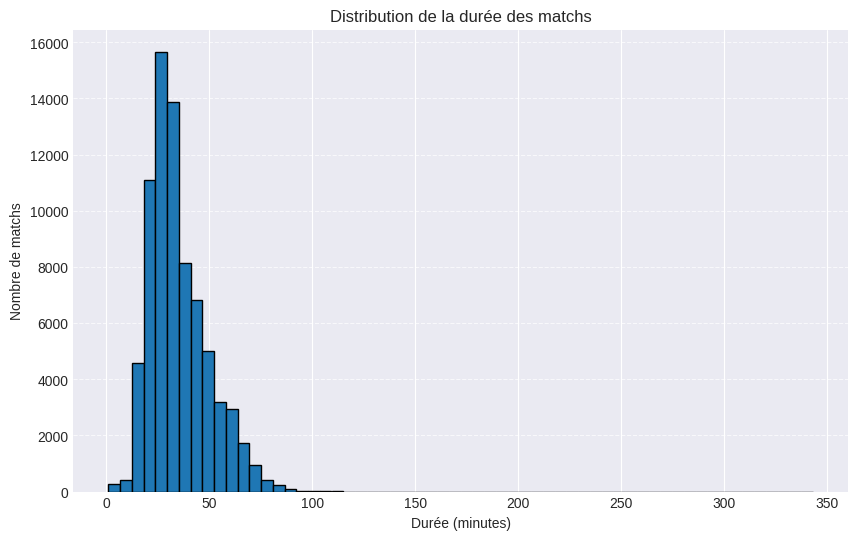

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(time["Duration"], bins=60, edgecolor='black')
plt.title("Distribution de la durée des matchs")
plt.xlabel("Durée (minutes)")
plt.ylabel("Nombre de matchs")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Nombre de matchs par année
df_matches_singles['Year'] = df_matches_singles['Date'].dt.year
matches_per_year = df_matches_singles.groupby('Year').size()
print("\nNombre de matchs par année :")
print(matches_per_year)


Nombre de matchs par année :
Year
2018    13407
2019    14897
2020     2655
2021     6365
2022    12197
2023    14581
2024    13996
dtype: int64


In [18]:
# Moyenne des points par set pour les sets 1 et 2
average_points_set1 = (
    df_matches_singles[['ScoreP1Set1', 'ScoreP2Set1']].sum(axis=1).mean()
)
average_points_set2 = (
    df_matches_singles[['ScoreP1Set2', 'ScoreP2Set2']].sum(axis=1).mean()
)

print(f"Moyenne des points par set dans le set 1 : {average_points_set1:.2f}")
print(f"Moyenne des points par set dans le set 2 : {average_points_set2:.2f}")


Moyenne des points par set dans le set 1 : 33.78
Moyenne des points par set dans le set 2 : 33.53


En moyenne les joueurs marquent à eux deux quasiment autant de points dans le premier que dans le 2e set.

# Partie 2 : Création du Système de Rating

## 2.1 Système traditionnel : ELO


Dans cette sous partie, nous allons programmer le système d'ELO originel (https://fr.wikipedia.org/wiki/Classement_Elo), afin de pouvoir le comparer ensuite à celui créé, ainsi qu'au système Glicko par exemple

In [19]:
df_matches_singles = df_matches_singles.sort_values(by=["Date", "MatchId"]) #Pour avoir les matchs dans l'ordre chronologique de 2018 à 2024

In [20]:
df_matches_singles

,MatchId,TournamentId,Date,EventId,Round,Player1Id,Player2Id,WinnerId,Duration,SetsP1,SetsP2,ScoreP1Set1,ScoreP2Set1,ScoreP1Set2,ScoreP2Set2,ScoreP1Set3,ScoreP2Set3,RetiredId,WalkoverId,Year
53964,97522,1727,2018-01-09,1,Qualification round of 16,16919,15682,16919,50.0,2.0,1.0,21.0,16.0,8.0,21.0,23.0,21.0,nan,nan,2018
53966,97526,1727,2018-01-09,1,Qualification round of 16,12774,12700,12700,27.0,0.0,2.0,15.0,21.0,14.0,21.0,NaN,NaN,nan,nan,2018
53968,97530,1727,2018-01-09,1,Qualification round of 16,17120,12931,17120,58.0,2.0,1.0,18.0,21.0,21.0,15.0,21.0,17.0,nan,nan,2018
53971,97537,1727,2018-01-09,1,Qualification round of 16,15538,12716,15538,30.0,2.0,0.0,21.0,7.0,21.0,18.0,NaN,NaN,nan,nan,2018
53974,97543,1727,2018-01-09,1,Qualification quarter final,15538,12732,12732,36.0,0.0,2.0,18.0,21.0,18.0,21.0,NaN,NaN,nan,nan,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78060,262277,3432,2024-12-28,1,Quarter final,60868,29386,29386,61.0,1.0,2.0,21.0,23.0,21.0,15.0,21.0,23.0,nan,nan,2024
78066,262283,3432,2024-12-28,1,Quarter final,29556,32114,29556,28.0,2.0,0.0,21.0,16.0,21.0,11.0,NaN,NaN,nan,nan,2024
78080,262306,3432,2024-12-28,1,Quarter final,48607,50939,48607,45.0,2.0,1.0,21.0,17.0,13.0,21.0,21.0,13.0,nan,nan,2024
78081,262307,3432,2024-12-28,1,Semi final,48607,29386,48607,38.0,2.0,0.0,24.0,22.0,21.0,12.0,NaN,NaN,nan,nan,2024


In [21]:
initial_elo = 1800


On va créer des colonnes pour stocker les ELO avant et après le match, ce qui permettra par la suite d'évaluer les progressions des joueurs par exemple. 
Avant chaque match la boucle calcule la probabilité de gagner pour chaque joueur par rapport à son ELO, et après le match, elle attribue les points d ELO grâce au système classique.


In [22]:
# 1. Création du DataFrame qui va stocker les ELO à partir de df_matches_singles
df_matches_elo = df_matches_singles.copy()

Le package elosports est utilisé pour gérer un système de classement ELO. Il permet :

-D'ajouter des joueurs avec un ELO initial (par défaut ou personnalisé).

-De mettre à jour les ELO après chaque match via la méthode gameOver(winner, loser, winnerHome).

-De paramétrer le facteur K pour ajuster la sensibilité du système.

Dans les données nous n'avons pas de classement initial des joueurs. On va donc leur attribuer un ELO de manière arbitraire. Prenons 1800
Il faut aussi choisir un facteur K , qui va déterminer la volatilité de l'ELO à chaque résultat. On va prendre 32, comme celui établi sur https://badmintonranks.com/other/about#elo

In [23]:
elo_system = Elo(k=32)

# Ajouter des colonnes pour stocker les ELO avant et après le match
df_matches_elo["Player1Elo"] = None
df_matches_elo["Player2Elo"] = None
df_matches_elo["Player1EloAfter"] = None
df_matches_elo["Player2EloAfter"] = None

# Trier les matchs par Date et MatchId
df_matches_elo = df_matches_elo.sort_values(by=["Date", "MatchId"]).reset_index(drop=True)

# Parcourir les matchs
for index, match in df_matches_elo.iterrows():
    # Récupérer les IDs des joueurs
    player1 = match["Player1Id"]
    player2 = match["Player2Id"]
    winner  = match["WinnerId"]

    # Ajouter les joueurs avec ELO initial s'ils ne sont pas dans le système
    if player1 not in elo_system.ratingDict:
        elo_system.addPlayer(player1, rating=initial_elo)
        
    if player2 not in elo_system.ratingDict:
        elo_system.addPlayer(player2, rating=initial_elo)
        

    # Stocker les ELO actuels des joueurs avant le match
    df_matches_elo.at[index, "Player1Elo"] = elo_system.ratingDict[player1]
    df_matches_elo.at[index, "Player2Elo"] = elo_system.ratingDict[player2]

    # Identifier le perdant
    loser = player2 if winner == player1 else player1

    # Mettre à jour les ELO après le match
    elo_system.gameOver(winner, loser, winnerHome=0.5)

    # Stocker les nouveaux ELO après le match
    df_matches_elo.at[index, "Player1EloAfter"] = elo_system.ratingDict[player1]
    df_matches_elo.at[index, "Player2EloAfter"] = elo_system.ratingDict[player2]




Le package ayant été developpé plutôt à des fins de sports collectifs, L'argument winnerHome sert à déterminer si l'équipe jouait à domicile. Comme dans notre cas ce ne sont pas des stades propres à chacun, on met 0.5 afin d'avoir comme un "terrain neutre". On aurait pu essayer de le faire avec les pays mais certains pays n'accueillent pas de compétition.

In [24]:
# Convertir les ratings ELO en DataFrame
elo_df = pd.DataFrame(list(elo_system.ratingDict.items()), columns=["PlayerId", "EloRating"])

elo_df=elo_df.sort_values(by="EloRating", ascending=False)

# Afficher les ELO finaux
display(elo_df)


,PlayerId,EloRating
498,12701,2409.559727
154,12695,2400.866543
144,12698,2350.608554
137,12705,2346.893655
3,12700,2328.142350
...,...,...
7629,29265,1625.576916
2666,14581,1624.226694
2205,13439,1612.258788
1321,13348,1564.949578


### Classements

In [25]:
# Pour tout avoir sur un seul df
elo_df_full = pd.merge(elo_df, df_male_p_full, on="PlayerId", how="left")

# Trier le DataFrame par EloRating dans l'ordre décroissant
elo_df_full = elo_df_full.sort_values(by="EloRating", ascending=False)

elo_df_full.index = elo_df_full.index + 1 #Pour avoir le rang explicite

display(elo_df_full.head(5))


,PlayerId,EloRating,LastName,FirstName,BirthDate,Height,Hand,Country,ShortName,Continent
1,12701,2409.559727,Shi,Yu Qi,1996-02-28 00:00:00,184.0,1.0,China,CHN,Asia
2,12695,2400.866543,Axelsen,Viktor,1994-01-04 00:00:00,194.0,1.0,Denmark,DEN,Europe
3,12698,2350.608554,Christie,Jonatan,1997-09-15 00:00:00,179.0,1.0,Indonesia,INA,Asia
4,12705,2346.893655,Antonsen,Anders,1997-04-27 00:00:00,183.0,1.0,Denmark,DEN,Europe
5,12700,2328.142350,Vitidsarn,Kunlavut,2001-05-11 00:00:00,173.0,1.0,Thailand,THA,Asia


On peut vraiment être satisfait du résultat si on veut le comparer au ranking BWF, au 31/12/2024 ! On a le même top 5 (certes pas dans le même ordre) et le même joueur numéro 1 mondial :
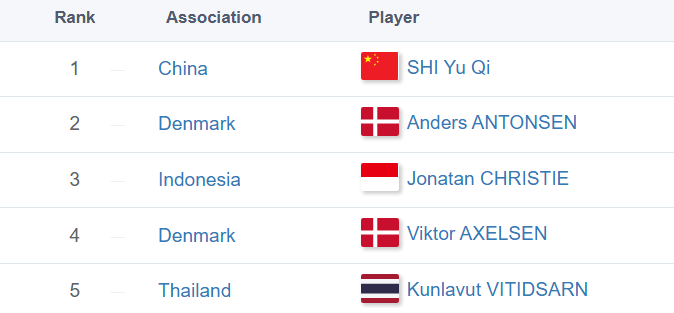

On remarque aussi qu'ils sont tous droitiers, malgré l'avantage des gauchers au badminton qu'on a tendance à attribuer à leur habitude de jouer contre des droitiers, là où l'inverse n'est pas vrai. D'ailleurs, il existe aussi un léger avantage purement physique, étudié par Éric Collet, Professeur à l'Institut de Physique de Rennes : https://hal.science/hal-04388731

Il faut tout de même noter que ce classement par ELO n'est pas parfaitement représentatif, dans la mesure où l'ampleur de la victoire/défaite n'est pas pris en compte dans les mouvements de points. De plus les victoires par forfait ou abandon de l'adversaire donnent exactement le même nombre de points qu'une victoire classique, ce qui ne traduit pas l'adversité du match. Aussi, le facteur K qui détermine la volatilité des points a été fixé de manière arbitraire, et le classement aurait sûrement été affecté par un K différent.

In [26]:
elo_by_continent = elo_df_full.groupby("Continent")["EloRating"].mean().sort_values(ascending=False)
display(elo_by_continent)


Continent
Asia           1809.075318
Europe         1795.610247
Pan America    1793.633065
Africa         1788.137943
Oceania        1788.016798
Name: EloRating, dtype: float64

On constate que seuls les joueurs asiatiques finissent avec une moyenne d'ELO au dessus de l'ELO initial (qui était de 1800). Les joueurs européens ne se défendent pas trop mal ceci dit.
Dans l'ensemble cela reste tout de même assez équilibré, aucun continent ne s'écarte drastiquement de l'ELO initial.

In [27]:
# Filtrer les joueurs français
french_players = elo_df_full[elo_df_full["Country"] == "France"]

# Trier les joueurs français par leur EloRating décroissant
french_players = french_players.sort_values(by="EloRating", ascending=False)

# Afficher les meilleurs joueurs français
display(french_players)


,PlayerId,EloRating,LastName,FirstName,BirthDate,Height,Hand,Country,ShortName,Continent
8,12739,2297.963115,Lanier,Alex,2005-01-26 00:00:00,180.0,NaN,France,FRA,Europe
26,12719,2191.716936,Popov,Toma Junior,1998-09-29 00:00:00,196.0,1.0,France,FRA,Europe
27,12723,2190.818978,Popov,Christo,2002-03-08 00:00:00,179.0,0.0,France,FRA,Europe
88,12738,2081.436201,Merkle,Arnaud,2000-04-25 00:00:00,NaN,NaN,France,FRA,Europe
109,12821,2069.305924,Roy,Enogat,2003-05-05 00:00:00,NaN,NaN,France,FRA,Europe
...,...,...,...,...,...,...,...,...,...,...
13240,50434,1749.198121,Thomas,Francois,1943-11-09 00:00:00,NaN,NaN,France,FRA,Europe
13258,30496,1748.432524,Morin,Louis,2007-02-19 00:00:00,NaN,NaN,France,FRA,Europe
13413,28559,1742.620173,Leroy,Dimitri,2008-04-04 00:00:00,NaN,NaN,France,FRA,Europe
13502,34911,1737.641874,Lovang,Kimi,2004-10-09 00:00:00,NaN,NaN,France,FRA,Europe


Les 3 meilleurs joueurs français sont (comme on pouvait s'en douter) : Alex LANIER, Toma Junior POPOV et son frère Christo. Ils sont respectivement 7e, 25 ET 26e mondiaux dans ce classement ELO.

### Progression des joueurs et comparaisons

On va analyser la progression d'ELO d'un ou plusieurs joueurs de notre choix. Grâce à la fonction search_player, si on connaît le nom ou le prénom d'un joueur on peut le chercher, afin de trouver son ID. Cet ID est ensuite utilisable dans la fonction plot_elo_comparison

In [28]:
search_player(elo_df_full, first_name="", last_name="Lanier")

,PlayerId,EloRating,LastName,FirstName,BirthDate,Height,Hand,Country,ShortName,Continent
8,12739,2297.963115,Lanier,Alex,2005-01-26 00:00:00,180.0,NaN,France,FRA,Europe
10375,14886,1782.046453,Lanier,Theo,2001-04-16 00:00:00,NaN,NaN,France,FRA,Europe


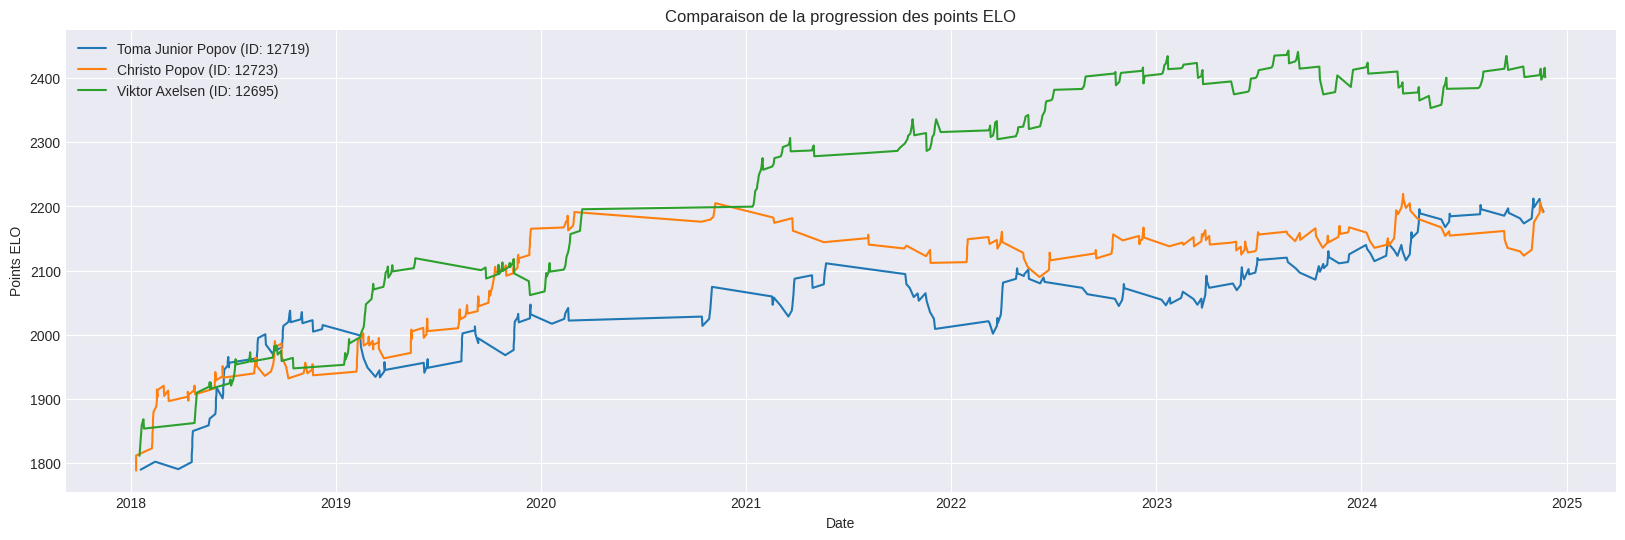

In [29]:
plot_elo_comparison([12719,12723,12695],df_matches_elo,df_male_players)


On compare ici par exemple les 2 frères POPOV, les stars du badminton français, avec Viktor AXELSEN la légende danoise. On voit que les 2 frères ont chacun eu à un moment une progression supérieure à AXELSEN, sur le début de la période, mais après le COVID, le Danois s'est envolé, là ou Christo POPOV a commencé à régresser légèrement. Toma Junior s'est quant à lui affaibli après la première année, avant de se reprendre et même dépasser son frère en 2024

## 2.2 Système Glicko 2 (déjà un peu modifié pour rester cohérent dans notre cadre)

But : Évaluer le niveau d’un joueur avec plus de précision qu’Elo en tenant compte de l’incertitude sur son niveau réel, et la régularité de ses performances.

Paramètres : 
- Rating (= Elo) ~> MU

- Rating Deviation : L'incertitude sur la fiabilité du rating. ~> PHI

- Volatilité (ajout spécifique à Glicko2 par rapport à Glicko) :  Indique les variations dans les performances du joueur ~> SIGMA

- Contrôle de la variation de Sigma au cours du temps ~> TAU




Puisque PHI représente l'incertitude sur le classement d'un joueur, plus PHI est élevé, moins le système considère le rating affiché précis. Par défaut PHI = 350, assez large pour prendre en compte l'incertitude lié aux nouveaux joueurs. Par conséquent, plus le nombre moyen de matchs par joueur est élevé plus on pourra réduire à la marge ce paramètre. On va donc calculer cette moyenne et éventuellement fixer un nouveau PHI.

In [30]:
# Étape 1 : Combiner les joueurs de Player1Id et Player2Id dans une seule liste
all_players = pd.concat([df_matches_singles['Player1Id'], df_matches_singles['Player2Id']])

# Étape 2 : On compte combien de fois chaque joueur a joué 
player_match_counts = all_players.value_counts()

# Étape 3 : Calculer la moyenne et l'écart-type
mean_match = player_match_counts.mean()  # Moyenne des matchs joués
std_match = player_match_counts.std()    # Écart-type des matchs joués

# Afficher les résultats
print(f"Nombre moyen de matchs joués : {mean_match}")
print(f"Écart-type du nombre de matchs : {std_match}")

Nombre moyen de matchs joués : 11.225815725168895
Écart-type du nombre de matchs : 27.17813608007626


On constate que l'écart type est très très élevé, ce qui signifie que le nombre de matchs joués varie beaucoup entre les joueurs. Par conséquent, la moyenne ne sera pas représentative et ne pourra pas servir de critère fiable pour fixer PHI. On va alors essayer la médiane.

In [31]:
median_match = player_match_counts.median()
median_match

3.0

La médiane est quant à elle très basse, ce qui ne va pas non plus nous aider. 

On va alors couper les joueurs en 3 groupes, en les classant par leur niveau d'activité. Cela servira ensuite à appliquer un PHI à chaque groupe, le plus petit étant pour le groupe avec plus de 20 matchs joués, et le plus grand pour un groupe inférieur à 5 matchs.

In [32]:
low_activity = (player_match_counts < 5).sum()
medium_activity = ((player_match_counts >= 5) & (player_match_counts <= 20)).sum()
high_activity = (player_match_counts > 20).sum()

print(f"Joueurs avec faible activité (<5 matchs) : {low_activity}")
print(f"Joueurs avec activité moyenne (5-20 matchs) : {medium_activity}")
print(f"Joueurs très actifs (>20 matchs) : {high_activity}")


Joueurs avec faible activité (<5 matchs) : 8570
Joueurs avec activité moyenne (5-20 matchs) : 3753
Joueurs très actifs (>20 matchs) : 1591


Attribuons un RD de 150 aux joueurs très actifs, 250 aux joueurs modérément actifs et 350 pour ceux à faible activité.

On importe les classes du module glicko2_perso, qui est la version légèrement modifiée du système glicko2 originel (https://github.com/sublee/glicko2/blob/master/glicko2.py). La possibilité d'une égalité a été retirée, et comme expliqué precédemment, le paramètre de RatingDeviation varie en fonction du nombre de matchs.
defaultdict est utilisé pour attribuer automatiquement un classement (Rating) à chaque nouveau joueur, afin d'éviter des vérifications manuelles pour savoir si un joueur est déjà présent dans le dictionnaire.

In [33]:
glicko = Glicko2()
ratings = defaultdict(lambda: glicko.create_rating())

In [37]:
# Convertir les classements en DataFrame
glicko_df = pd.DataFrame([
    {"PlayerId": player_id, "Mu": rating.mu, "Phi": rating.phi, "Sigma": rating.sigma}
    for player_id, rating in ratings.items()
])

glicko_df

,PlayerId,Mu,Phi,Sigma
0,16919,1831.544813,174.649146,0.060001
1,15682,2139.663180,75.680259,0.059973
2,12774,2342.364987,64.099497,0.059939
3,12700,2659.284600,63.141074,0.059737
4,17120,1977.149046,216.964709,0.059997
...,...,...,...,...
13909,62453,1399.969321,300.098965,0.060014
13910,62457,1716.549882,241.892224,0.060011
13911,62472,1726.773810,289.782649,0.059996
13912,62486,1663.296198,263.346870,0.059996


In [35]:
for _, match in df_matches_singles.iterrows():
    player1_id = match['Player1Id']
    player2_id = match['Player2Id']
    winner_id = match['WinnerId']
    
    # Récupérer les classements actuels
    rating1 = ratings[player1_id]
    rating2 = ratings[player2_id]
    
    # Mettre à jour les classements en fonction du gagnant
    if winner_id == player1_id:
        updated_rating1, updated_rating2 = glicko.rate_1vs1(rating1, rating2, winner=True)
    else:
        updated_rating1, updated_rating2 = glicko.rate_1vs1(rating1, rating2, winner=False)
    
    # Enregistrer les nouveaux classements
    ratings[player1_id] = updated_rating1
    ratings[player2_id] = updated_rating2


In [38]:
#Gros bug avec cette cellule, il faut re-éxécuter la cellule qui crée glicko_df (2 cellules au dessus) puis celle-ci

glicko_df_full = pd.merge(glicko_df, df_male_p_full, on="PlayerId", how="left")

In [39]:
glicko_df_full = glicko_df_full.rename(columns={"Mu" : "Points" , "Phi" : "Rating Deviation", "Sigma" : "Volatility"})

# Trier le DataFrame par EloRating dans l'ordre décroissant
glicko_df_full = glicko_df_full.sort_values(by="Points", ascending=False).reset_index(drop=True)
glicko_df_full.index = glicko_df_full.index + 1 #Pour avoir le rang explicite

display(glicko_df_full.head(10))

,PlayerId,Points,Rating Deviation,Volatility,LastName,FirstName,BirthDate,Height,Hand,Country,ShortName,Continent
1,12695,2765.164613,67.776124,0.059567,Axelsen,Viktor,1994-01-04 00:00:00,194.0,1.0,Denmark,DEN,Europe
2,12701,2757.600186,65.196236,0.059765,Shi,Yu Qi,1996-02-28 00:00:00,184.0,1.0,China,CHN,Asia
3,12698,2684.559503,62.224235,0.059824,Christie,Jonatan,1997-09-15 00:00:00,179.0,1.0,Indonesia,INA,Asia
4,12705,2679.287702,62.873420,0.059805,Antonsen,Anders,1997-04-27 00:00:00,183.0,1.0,Denmark,DEN,Europe
5,12700,2659.284600,63.141074,0.059737,Vitidsarn,Kunlavut,2001-05-11 00:00:00,173.0,1.0,Thailand,THA,Asia
6,12704,2641.999519,62.494221,0.059900,Lee,Zii Jia,1998-03-29 00:00:00,186.0,1.0,Malaysia,MAS,Asia
7,12699,2640.769709,62.590604,0.059931,Li,Shi Feng,2000-01-09 00:00:00,NaN,NaN,China,CHN,Asia
8,51851,2608.002198,131.916909,0.059979,Schytt,Gregers,1974-04-14 00:00:00,NaN,NaN,Denmark,DEN,Europe
9,47719,2606.450084,112.971084,0.059957,Antonsson,Jan-Eric,1961-09-09 00:00:00,183.0,1.0,Sweden,SWE,Europe
10,12697,2604.530149,62.314158,0.059686,Naraoka,Kodai,2001-06-30 00:00:00,NaN,NaN,Japan,JPN,Asia


On retrouve le même top 5 que dans le classement ELO ! Mais cette fois Viktor AXELSEN devance de peu SHI Yu Qi. Le RD de chacun est très faible ce qui nous indique qu'ils ont joué beaucoup de matchs, ce qui laisse peu de doute au système sur la fiabilité de leurs ratings. 

On remarque qu'avec le système Glicko2, le nombre de points finaux est supérieur à celui de l'ELO

In [40]:
print(elo_df_full["EloRating"].mean())
print(elo_df_full["EloRating"].std())

1800.0
52.748752134492634


In [41]:
print(glicko_df_full["Points"].mean())
print(glicko_df_full["Points"].std())

1742.5911627115947
215.52083489248372


Malgré un nombre de points finaux plus élevé dans le système de Glicko2, la moyenne est inférieure à celle du classement ELO. En revanche, l'écart type y est 4 fois plus élevé. On peut en déduire que Glicko2 a un meilleur pouvoir de différenciation,  en espaçant davantage leurs niveaux. En fait dans ELO, il se passe une sorte de simple "redistribution de points". Par conséquent la plupart des joueurs se retrouvent autour de la moyenne qui est en fait l'ELO initial.

Le système Glicko2 semble plus juste et permet d'avoir une meilleure estimation des performances, déja en prenant en compte le nombre de matchs joués et l'incertitude qui y est liée, ainsi que la volatilité qui permet une meilleure réactivité aux changements de performances

In [42]:
french_players_gl = glicko_df_full[glicko_df_full["Country"] == "France"]

# Trier les joueurs français par leur Points Glicko décroissants.
french_players_gl = french_players_gl.sort_values(by="Points", ascending=False).reset_index(drop=True)

# Afficher les meilleurs joueurs français
display(french_players_gl.head(10))


,PlayerId,Points,Rating Deviation,Volatility,LastName,FirstName,BirthDate,Height,Hand,Country,ShortName,Continent
0,12739,2604.213488,62.383658,0.059634,Lanier,Alex,2005-01-26 00:00:00,180.0,NaN,France,FRA,Europe
1,12723,2487.118253,62.361338,0.059693,Popov,Christo,2002-03-08 00:00:00,179.0,0.0,France,FRA,Europe
2,12719,2481.228097,62.260167,0.059794,Popov,Toma Junior,1998-09-29 00:00:00,196.0,1.0,France,FRA,Europe
3,16934,2413.394247,144.623157,0.060029,Cajot,Pierrick,1994-04-18 00:00:00,NaN,NaN,France,FRA,Europe
4,50352,2407.687548,105.556577,0.059968,Lionne,Christophe,1971-12-01 00:00:00,NaN,NaN,France,FRA,Europe
5,12738,2363.502127,63.596032,0.059778,Merkle,Arnaud,2000-04-25 00:00:00,NaN,NaN,France,FRA,Europe
6,20105,2298.687210,137.336456,0.060025,Nelson,Anthony,1984-09-05 00:00:00,NaN,NaN,France,FRA,Europe
7,53211,2296.266429,126.962963,0.059972,Blondeau,Thomas,1977-07-07 00:00:00,NaN,NaN,France,FRA,Europe
8,12821,2285.007742,62.470740,0.059468,Roy,Enogat,2003-05-05 00:00:00,NaN,NaN,France,FRA,Europe
9,50466,2264.836916,109.010722,0.059981,Bontemps,Jean-Jacques,1962-08-27 00:00:00,NaN,1.0,France,FRA,Europe


Le top 3 français ne change pas , mais les 2 qui complètent le top 5 sont différents de ceux qu'on avait lors du système d'ELO. Cependant leurs RD sont plus élevés ce qui peut laisser penser que leur classement est peut-être un peu surestimé, bien qu'ils aient aussi joué beaucoup de matchs

In [43]:
eu_players_gl = glicko_df_full[glicko_df_full["Continent"] == "Europe"]

# Trier les joueurs européens par leur Points Glicko décroissants.
eu_players_gl = eu_players_gl.sort_values(by="Points", ascending=False).reset_index(drop=True)
eu_players_gl.index = eu_players_gl.index + 1 #Pour avoir le rang explicite

# Afficher les meilleurs joueurs européens
display(eu_players_gl.head(10))




,PlayerId,Points,Rating Deviation,Volatility,LastName,FirstName,BirthDate,Height,Hand,Country,ShortName,Continent
1,12695,2765.164613,67.776124,0.059567,Axelsen,Viktor,1994-01-04 00:00:00,194.0,1.0,Denmark,DEN,Europe
2,12705,2679.287702,62.873420,0.059805,Antonsen,Anders,1997-04-27 00:00:00,183.0,1.0,Denmark,DEN,Europe
3,51851,2608.002198,131.916909,0.059979,Schytt,Gregers,1974-04-14 00:00:00,NaN,NaN,Denmark,DEN,Europe
4,47719,2606.450084,112.971084,0.059957,Antonsson,Jan-Eric,1961-09-09 00:00:00,183.0,1.0,Sweden,SWE,Europe
5,12739,2604.213488,62.383658,0.059634,Lanier,Alex,2005-01-26 00:00:00,180.0,NaN,France,FRA,Europe
6,50294,2560.670611,103.128722,0.059955,Storvik,Geir Olve,1962-07-19 00:00:00,NaN,1.0,Norway,NOR,Europe
7,50261,2519.927624,114.156268,0.059984,Hukriede,Thorsten,1976-07-06 00:00:00,NaN,NaN,Germany,GER,Europe
8,12723,2487.118253,62.361338,0.059693,Popov,Christo,2002-03-08 00:00:00,179.0,0.0,France,FRA,Europe
9,12722,2484.055553,62.373592,0.059901,Gemke,Rasmus,1997-01-11 00:00:00,185.0,1.0,Denmark,DEN,Europe
10,12719,2481.228097,62.260167,0.059794,Popov,Toma Junior,1998-09-29 00:00:00,196.0,1.0,France,FRA,Europe


Il y a 3 français dans le top 10 européen, c'est un bon ratio et d'ailleurs le meilleur après le Danemark.

In [44]:
# ON filtre les 100 meilleurs joueurs européens et mondiaux
top_100_eu_players = eu_players_gl.head(100)
top_100_world_players = glicko_df_full.head(100)


# Étape 2 : Filtrer les joueurs français parmi eux
french_top_100_eu = top_100_eu_players[top_100_eu_players["Country"] == "France"]
french_top_100_world = top_100_world_players[top_100_world_players["Country"] == "France"]


# Étape 3 : Calculer le nombre de joueurs français dans chaque top
french_prop_eu = len(french_top_100_eu)
french_prop_world = len(french_top_100_world)

# Afficher les résultats
print(f"Il y a {french_prop_eu} joueurs français dans le top 100 européen")
print(f"Il y a {french_prop_world} joueurs français dans le top 100 mondial")



Il y a 11 joueurs français dans le top 100 européen
Il y a 4 joueurs français dans le top 100 mondial


Il y a peu de joueurs français dans le top 100 européen et encore moins dans le top 100 mondial. Cependant, il faut se dire que cela reste une performance correcte, puisqu'on sait que le badminton est loin d'être le sport national, comparé à certains pays d'Asie par exemple.

In [45]:
search_player(glicko_df_full, first_name="Alex", last_name="Lanier")
#Réutilsation de la fonction pour voir le classement mondial d'un joueur spécifique avec le classement glicko

,PlayerId,Points,Rating Deviation,Volatility,LastName,FirstName,BirthDate,Height,Hand,Country,ShortName,Continent
11,12739,2604.213488,62.383658,0.059634,Lanier,Alex,2005-01-26 00:00:00,180.0,NaN,France,FRA,Europe


## 2.3 Création de mon système personnel de Rating : SmartRank

### Système de Notation Proposé : SmartRank (version alternative de Glicko2)

#### 1. Points de Base
- Chaque joueur commence avec un total initial de **1800 points**.

#### 2. Écart de Rang entre Joueurs
- Intégration d'une métrique d'écart de rang basée sur un modèle de type **rating dynamique** (inspiré du système Glicko-2), prenant en compte :
  - Le nombre total de matchs joués.
  - La variance des performances individuelles.
- **Bonus pour l'outsider :** 
  - Si l'écart entre les joueurs est significatif et que le joueur moins bien classé remporte la victoire, un bonus proportionnel est attribué.

#### 3. Ampleur de la Défaite
- Calcul des points en fonction de la performance globale dans le match :
  - Nombre de points marqués par rapport au total du gagnant.
  - Inclusion ou non de points supplémentaires si au moins un set a été remporté par le perdant.

#### 4. Abandons et Forfaits
- Suppression de l'attribution de points en cas de victoire par **forfait** ou **abandon**.
- **Pénalité forfaitaire :**
  - Imposition d'une pénalité pour les joueurs déclarant forfait ou qui abandonnent en cours de match, avec des sanctions plus sévères pour les forfaits.

#### 5. Pondération selon l'Importance du Tournoi
- Les points attribués sont ajustés en fonction du niveau du tournoi (par grade).

#### 6. Progression par Tour
- **Bonus croissant** en fonction de la progression dans le tournoi à partir des quarts de finale.


In [46]:
df_matches_full = df_matches_singles.merge(
    df_male_p_full,
    left_on="Player1Id",
    right_on="PlayerId",
    how="left"
).merge(
    df_male_p_full,
    left_on="Player2Id",
    right_on="PlayerId",
    suffixes=("_Player1", "_Player2"),
    how="left"
)

In [47]:
columns_to_drop = ["PlayerId_Player1", "EventId","PlayerId_Player2",  
    "Hand_Player1", "Hand_Player2", 
    "BirthDate_Player1", "BirthDate_Player2", 
    "Height_Player1", "Height_Player2",
]

df_matches_full = df_matches_full.drop(columns=columns_to_drop)


In [48]:
# Remplir les valeurs manquantes par 0 avant de calculer les totaux
df_matches_full["TotalPoints_Player1"] = (
    df_matches_full["ScoreP1Set1"].fillna(0) + 
    df_matches_full["ScoreP1Set2"].fillna(0) + 
    df_matches_full["ScoreP1Set3"].fillna(0)
)

df_matches_full["TotalPoints_Player2"] = (
    df_matches_full["ScoreP2Set1"].fillna(0) + 
    df_matches_full["ScoreP2Set2"].fillna(0) + 
    df_matches_full["ScoreP2Set3"].fillna(0)
)


In [49]:
# Fusionner df_tournament_full et df_matches_full
df_matches_full = df_matches_full.merge(
    df_tournament_full,  # DataFrame contenant TournamentId, CategoryId, CategoryName et Grade
    how="left",  
    on="TournamentId" 
)


In [50]:
# 1. Créer une instance de SmartRank
sr = SmartRank()

# 2. Créer un dictionnaire pour stocker les ratings des joueurs
player_ratings = {}

# 3. Parcourir les matches et mettre à jour les ratings
for index, match in df_matches_full.iterrows():

    points_p1, points_p2 = sr.calculate_points(match)
    
    # Mettre à jour les ratings dans le dictionnaire
    player_ratings[match['Player1Id']] = Rating(mu=points_p1)
    player_ratings[match['Player2Id']] = Rating(mu=points_p2)

# 4. Créer un nouveau dataframe avec les ratings finaux
ratings_data = []
for player_id, rating in player_ratings.items():
    ratings_data.append({
        'PlayerId': player_id,
        'Rating': rating.mu,
        'RatingDeviation': rating.phi,
        'Volatility': rating.sigma
    })



In [51]:
# Créer et trier le dataframe des ratings
smartrank_df = pd.DataFrame(ratings_data)
smartrank_df = smartrank_df.sort_values('Rating', ascending=False)
smartrank_df = smartrank_df.reset_index(drop=True)

# Fusionner avec les informations des joueurs
smartrank_df_full = smartrank_df.merge(df_male_p_full, on='PlayerId', how='left')
display(smartrank_df_full.head(15))

,PlayerId,Rating,RatingDeviation,Volatility,LastName,FirstName,BirthDate,Height,Hand,Country,ShortName,Continent
0,47517,3597.349830,350,0.06,Mainaky,Marleve,1972-03-26 00:00:00,178.0,1.0,Indonesia,INA,Asia
1,47892,3518.221175,350,0.06,Garip,Bruni,1952-09-14 00:00:00,NaN,NaN,Malaysia,MAS,Asia
2,47719,3496.035837,350,0.06,Antonsson,Jan-Eric,1961-09-09 00:00:00,183.0,1.0,Sweden,SWE,Europe
3,12701,3495.797784,350,0.06,Shi,Yu Qi,1996-02-28 00:00:00,184.0,1.0,China,CHN,Asia
4,12695,3467.755665,350,0.06,Axelsen,Viktor,1994-01-04 00:00:00,194.0,1.0,Denmark,DEN,Europe
5,51851,3439.921010,350,0.06,Schytt,Gregers,1974-04-14 00:00:00,NaN,NaN,Denmark,DEN,Europe
6,12705,3416.661583,350,0.06,Antonsen,Anders,1997-04-27 00:00:00,183.0,1.0,Denmark,DEN,Europe
7,12698,3411.239906,350,0.06,Christie,Jonatan,1997-09-15 00:00:00,179.0,1.0,Indonesia,INA,Asia
8,47021,3402.743711,350,0.06,Diniola,Nazriel Ezy,2007-05-19 00:00:00,NaN,NaN,Indonesia,INA,Asia
9,51894,3386.331057,350,0.06,Kasayapanan,Karoon,1965-11-22 00:00:00,NaN,1.0,Thailand,THA,Asia


Malheureusement par manque de temps et malgré une centaine d'essais, je n'ai pas réussi à implémenter correctement mon SmartRank. On obtient un top où les volatilités et les RD n'ont pas été mis à jour après chaque match. Le top 3 mondial est composé de joueurs retraités... Cependant SHI Yu Qi et Viktor AXELSEN sont fidèles au rendez-vous du top 5, ce qui console un peu  :  le classement n'est pas totalement dénué de sens. Il y a d ailleurs nos protagonistes du top 5 habituel un peu plus loin dans le classement.

# Partie 3 : Analyse Prédictive des résultats

Pour prédire les résultats, j'ai pensé à 3 façons de faire :

**Regréssion Logistique (Modèle Logit)** :  La régression logistique est un modèle statistique utilisé pour prédire la probabilité d'une issue binaire (par exemple, victoire ou défaite).
Dans notre cadre, on pourrait l'utiliser pour prédire la probabilité qu'un joueur gagne un match en fonction de variables telles que son classement et celui de l'adversaire, leur historique de matchs, ou d'autres caractéristiques pertinentes.

      Avantages : facile à interpréter, rapide à entraîner

      Limites : Repose sur une hypothèse de linéarité qui n'est probablement pas vérifiée dans nos données. Les valeurs aberrantes peuvent affecter la qualité des coefficients estimés.


**Boosting** : Le boosting crée une série de modèles de manière séquentielle, chaque modèle successif corrigeant les erreurs du précédent. Cette approche rend le modèle très performant, surtout pour les données complexes, bien qu'elle soit plus susceptible de surapprentissage si les paramètres ne sont pas correctement ajustés.

        Avantages : Le boosting est souvent plus performant que les modèles individuels, comme la régression logistique, en capturant des relations complexes entre les variables. Il est assez flexible

        Limites : Peut être long, risque d'overfitting, sensible aux hyperparamètres

- **Classification Naïve Bayésienne** : La classification bayésienne naïve est un algorithme basé sur le théorème de Bayes, qui suppose que les variables explicatives sont conditionnellement indépendantes les unes des autres.

      Avantages : Facile à mettre en place, très rapide à entrainer.

      Limites : L'hypothèse d'indépendance conditionnelle pourrait être trop forte dans notre cadre. Les probabibilités conditionnelles peuvent être difficiles à interpréter.


- **Reinforcement Learning** : Branche du Machine Learning c'est "une méthode d'apprentissage automatique où un agent apprend à prendre des décisions en interagissant avec un environnement. L'agent reçoit des récompenses ou des pénalités en fonction de ses actions, et son objectif est de maximiser la récompense cumulative"
Dans notre cadre, il pourrait être utilisé pour modéliser :La stratégie optimale d’un joueur au cours d’un tournoi ou d’un match, la manière dont il réagit après une victoire ou une défaite (rebondit-il après une défaite ou s'enferme-t-il dans une spirale négative ?).

        Avantages : Le RL est performant sur des modèles complexes, il s'adapte facilement à des environnements dynamiques comme le nôtre. De plus il est idéal pour faire des simulations

        Limites : Très gourmand en calcul et nécessite des connaissances très avancées. De plus il serait préférable d'avoir des données séquentielles plus pointues (telles que les matchs point par  point)

## 3.1 Modèle Logit - Régression Logistique

Pour effectuer cette régression logistique on va partir de df_matches_full mais en ajoutant les points Glicko2 de chaque joueur avant le match. Cela permettra d'utiliser leur écart de point comme variable explicative. Je prends Glicko2 car il est plus pertinent que ELO, et SmartRank présente trop de soucis pour le moment.

In [52]:
glicko2 = Glicko2()

In [53]:
player_ratings = {}  # Dictionnaire pour stocker les ratings

for index, match in df_matches_full.iterrows():
    player1_id = match['Player1Id']
    player2_id = match['Player2Id']
    winner_id = match['WinnerId']

    # Récupérer les classements existants ou initialiser
    rating_p1 = player_ratings.get(player1_id, glicko2.create_rating())
    rating_p2 = player_ratings.get(player2_id, glicko2.create_rating())

    # Calcul des nouveaux ratings
    if winner_id == player1_id:
        new_rating_p1, new_rating_p2 = glicko2.rate_1vs1(rating_p1, rating_p2, winner=True)
    else:
        new_rating_p1, new_rating_p2 = glicko2.rate_1vs1(rating_p1, rating_p2, winner=False)

    # Mise à jour des ratings dans le dictionnaire
    player_ratings[player1_id] = new_rating_p1
    player_ratings[player2_id] = new_rating_p2

    # Ajouter les classements au DataFrame
    df_matches_full.at[index, 'Rating_Player1'] = rating_p1.mu
    df_matches_full.at[index, 'Rating_Player2'] = rating_p2.mu

    #Calculer l'écart de points entre les 2 joueurs.
    df_matches_full['RatingDifference'] = abs(df_matches_full['Rating_Player1'] - df_matches_full['Rating_Player2'])



Il y a une petite proportion de valeurs manquantes sur les rounds et les durées de match, on va donc les enlever pour élever la précision du modèle, mais on ne perd pas trop d'informations. On aurait pu également remplacer la durée des matchs manquantes par la médiane.

In [54]:
df_matches_full = df_matches_full.dropna(subset=["Duration","Round"])


Maintenant que notre dataframe est prêt on va passer au modèle.

On commence par créer la variable binaire Player1Wins qui est True si le joueur 1 gagne, False sinon.

In [55]:
df_matches_full['Player1Wins'] = (df_matches_full['WinnerId'] == df_matches_full['Player1Id']) 

In [56]:
#  Préparation des données numériques
features_num = [
    'RatingDifference',
    'Rating_Player1',
    'Rating_Player2',
    'Duration'
]

X_num = df_matches_full[features_num]

# Encodage de la variable 'Round' car c'est une variable qualitative
encoder = OneHotEncoder(sparse=False, drop="first")
X_round = encoder.fit_transform(df_matches_full[["Round"]])

# Combiner les features numériques et encodées
X = np.hstack([X_num, X_round])

# Variable à prédire
y = df_matches_full["Player1Wins"]

#  Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Création et entraînement du modèle
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Prédictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

#  Évaluation du modèle
precision = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Précision du modèle : {precision:.2%}")
print(f"Score AUC ROC : {auc_score:.2%}")

# 9. Affichage des coefficients pour les variables numériques
print("\nImportance des variables numériques:")
for feature, coef in zip(features_num, model.coef_[0][:len(features_num)]):
    print(f"{feature}: {coef:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Précision du modèle : 69.15%
Score AUC ROC : 76.06%

Importance des variables numériques:
RatingDifference: 0.0144
Rating_Player1: 1.2803
Rating_Player2: -1.2706
Duration: -0.0035


Avec une précision (accuracy) de 69,15 %, mon modèle parvient à prédire correctement le gagnant dans environ 7 cas sur 10. Cela dépasse largement un tirage aléatoire (50 %), mais il reste encore une grosse marge d'amélioration pour obtenir de meilleures performances.

De plus, l'AUC ROC de 76,06 % est jugée acceptable (> 70 %), ce qui montre que le modèle a une certaine capacité à distinguer entre les victoires et les défaites, même si des ajustements pourraient renforcer cette distinction.

On voit au niveau des variables numériques, que comme on s'en doute le fait d'etre mieux classé que son adversaire augmente la probabilité de victoire. La durée du match quant à elle n'a que peu d'importance, ce qui est logique car elle affecte les 2 joueurs en même temps.

## 3.2 Boosting

In [57]:
# Préparation des données numériques
features_num = [
    'RatingDifference',
    'Rating_Player1',
    'Rating_Player2',
    'Duration'
]

X_num = df_matches_full[features_num]

# Encodage de la variable 'Round' car c'est une variable qualitative
encoder = OneHotEncoder(sparse=False, drop="first")
X_round = encoder.fit_transform(df_matches_full[["Round"]])

# 3. Combiner les features numériques et encodées
X = np.hstack([X_num, X_round])

# Variable à prédire
y = df_matches_full["Player1Wins"]

#  Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBClassifier(
    n_estimators=100,     # nombre d'arbres
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Le reste du code reste identique
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

precision = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Précision du modèle : {precision:.2%}")
print(f"Score AUC ROC : {auc_score:.2%}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Précision du modèle : 69.61%
Score AUC ROC : 78.26%


La précision avec du Boosting tout simple n'a presque pas augmenté. Cependant on sait que le Boosting dépend de ses hyperparamètres. On va alors fare un test avec plusieurs valeurs, ainsi on pourra refaire tourner le modèle avec de bons hyperparamètres. On utilise la Cross-Validation à 5 folds, qui permet de tester chaque combinaison d'hyperparamètres de manière robuste.

In [58]:
# Création du modèle avec les hyperparamètres à tester
model = XGBClassifier(random_state=42)

# Grille des hyperparamètres à tester
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],     # taux d'apprentissage
    'max_depth': [3, 5, 7],                # profondeur maximale des arbres
    'n_estimators': [100]                  
}

# Recherche par grille avec validation croisée
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5,                    # validation croisée en 5 fois
    scoring='accuracy'      # optimisation sur le score d'accuracy
                  # pour voir l'avancement
)

# Entraînement
grid_search.fit(X_train_scaled, y_train)

# Affichage des meilleurs paramètres
print("\nMeilleurs paramètres trouvés:")
print(grid_search.best_params_)

# Utilisation du meilleur modèle pour les prédictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Évaluation
precision = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\nPrécision du modèle optimisé : {precision:.2%}")
print(f"Score AUC ROC optimisé : {auc_score:.2%}")


Meilleurs paramètres trouvés:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Précision du modèle optimisé : 70.44%
Score AUC ROC optimisé : 78.39%


On a encore une fois très légèrement augmenté la précision et l'AUC mais rien de très satisfaisant. Le Boosting reste lui aussi limité pour nos données.

## 3.3 Classification Naïve Bayésienne

In [59]:

features_num = [
    'RatingDifference',
    'Rating_Player1',
    'Rating_Player2',
    'Duration'
]

X_num = df_matches_full[features_num]


encoder = OneHotEncoder(sparse=False, drop="first")
X_round = encoder.fit_transform(df_matches_full[["Round"]])


X = np.hstack([X_num, X_round])


y = df_matches_full["Player1Wins"]

# 4. Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Création et entraînement du modèle Naive Bayes
nb_model = GaussianNB()


#  Entraînement sur l'ensemble complet
nb_model.fit(X_train_scaled, y_train)


y_pred = nb_model.predict(X_test_scaled)
y_pred_proba = nb_model.predict_proba(X_test_scaled)[:, 1]


precision = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\nPrécision du modèle : {precision:.2%}")
print(f"Score AUC ROC : {auc_score:.2%}")



Précision du modèle : 50.03%
Score AUC ROC : 68.72%


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


La Classification bayésienne naïve est très mauvaise, elle ne fait même pas mieux que l'aléatoire.

# Partie 4 : Axes d'amélioration du projet

Dans la base de données, les nombreuses valeurs manquantes ont limité les possibilités de variable à inclure dans les modèles de prédiction. Il aurait par exemple été interessant de voir si le fait d'être gaucher donnait un réel avantage, comme on a pu en parler au début. Les variables telles que l'âge ou le grade du tournoi auraient aussi pu rentrer en ligne de compte.
J'aurais aimé ajouter des colonnes telles que le nombre de victoires sur les 5 derniers matchs, et d'autres indicateurs de la forme actuelle.
J'ai mentionné aussi le Reinforcement Learning, qui dépasse mes compétences et est trop limité par les données mais qui aurait été selon moi un des meilleurs choix

Comme vous l'avez vu, l'implémentation de SmartRank n'a pas fonctionné comme espéré, c'est donc aussi un des points à revoir, afin d'avoir un classement hyper représentatif des joueurs. 
Je n'ai malheureusement pas eu le temps non plus d'élargir mes systèmes de rating aux matchs en double. 

Concernant l'optimisation des hyperparamètres, l'utilisation d'une librairie comme Optuna aurait été utile (découverte trop tard).
